## Iris data analysis
**Step:**
- Get data
- Data set split
- Data standardization
- Model training
- GridSearchCV
- K-fold cross-validation
- Nested cross-validation
- Roc curve
- Learning curve
- Validation curve

### Get data
- Import the package to be used, then get the iris data from the sklearn package and print the data information。

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
from sklearn import datasets, svm
from itertools import cycle
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, ShuffleSplit, cross_val_score
# Ignore warnings due to version issues
warnings.filterwarnings('ignore')

In [2]:
# Get data and show information
iris = datasets.load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
iris.data.shape

(150, 4)

In [6]:
iris.target.shape

(150,)

In [7]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])

In [8]:
X.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3
149,5.9,3.0,5.1,1.8


In [9]:
y.tail()

,species
145,2
146,2
147,2
148,2
149,2


In [10]:
# Concatnate iris.data and iris.target set, draw pairplot to show the relationship between every two variables.
data = pd.concat([X, y], axis=1)
try:
    data.loc[:, 'species'][data['species'] == 0] = iris.target_names[0]
    data.loc[:, 'species'][data['species'] == 1] = iris.target_names[1]
    data.loc[:, 'species'][data['species'] == 2] = iris.target_names[2]
except Exception as err:
    print(err)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


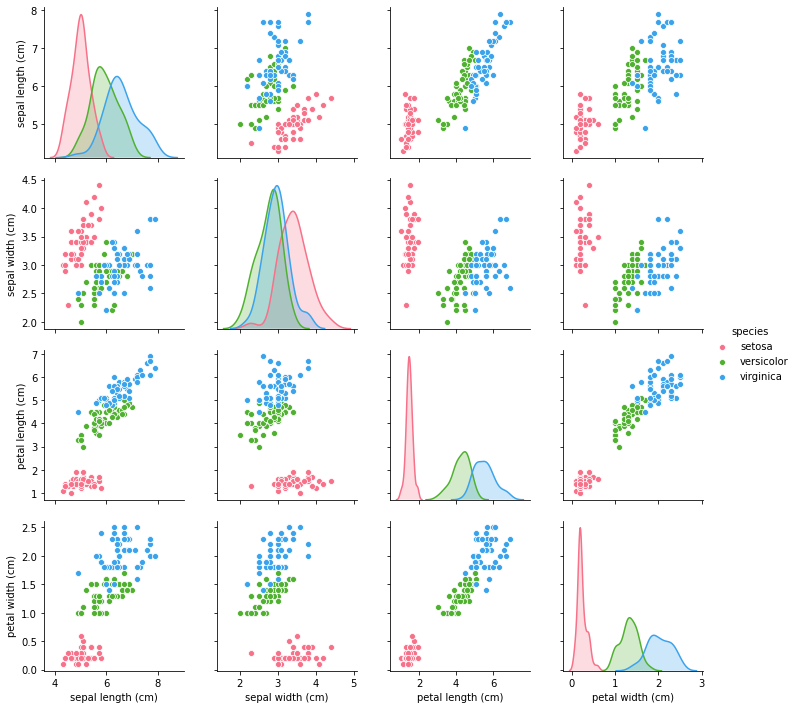

In [11]:
# Draw pairplot
sns.pairplot(data, hue='species', palette='husl')
plt.show()

### Data set split
- Split data set, test_size = 0.4.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=66, stratify=y)

In [13]:
x_train.shape, x_test.shape

((90, 4), (60, 4))

In [14]:
y_train.shape, y_test.shape

((90, 1), (60, 1))

### Standardization
- Standardize the data and improve the accuracy of training model

In [15]:
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [16]:
X = sc.transform(X)

In [17]:
x_train.mean(), x_test.var()

(7.302800339756585e-16, 1.2337774135476403)

### Model training
- SVM classifier  

In [18]:
clf = svm.SVC()
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [19]:
# show model prediction accuracy
y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

0.9833333333333333

In [20]:
# Show confusion matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[20,  0,  0],
       [ 0, 19,  1],
       [ 0,  0, 20]], dtype=int64)

### GridSearchCV
- Grid search and cross validation to find the optimal super parameters

In [21]:
# Given super parameter value range
param_range = [0.001, 0.01, 0.1, 1, 10.0, 100]
param_grid = [{'C': param_range, 'kernel': ['linear']},
            {'C': param_range, 'kernel': ['rbf'], 'gamma':param_range}]
# Cross validation k = 10, divide the data into the same 10 groups
kfold = StratifiedKFold(n_splits=10, random_state=66)
clf = svm.SVC()
# Scoring specifies the loss function type, CV specifies cross validation
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

In [22]:
# grid_scores_：The evaluation results under different parameters are given.
# best_params_：Describes the combination of parameters that have achieved the best results.
# best_score_：Provide the best score observed during the optimization process.
print("Best score: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# Show Accuracy of the model under each parameter
for mean,param in zip(means,params):
    print("Score: %f  with:   %r" % (mean,param))

Best score: 0.988889 using {'C': 10.0, 'kernel': 'linear'}
Score: 0.877778  with:   {'C': 0.001, 'kernel': 'linear'}
Score: 0.877778  with:   {'C': 0.01, 'kernel': 'linear'}
Score: 0.944444  with:   {'C': 0.1, 'kernel': 'linear'}
Score: 0.955556  with:   {'C': 1, 'kernel': 'linear'}
Score: 0.988889  with:   {'C': 10.0, 'kernel': 'linear'}
Score: 0.988889  with:   {'C': 100, 'kernel': 'linear'}
Score: 0.877778  with:   {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
Score: 0.877778  with:   {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
Score: 0.866667  with:   {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
Score: 0.922222  with:   {'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}
Score: 0.766667  with:   {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'}
Score: 0.422222  with:   {'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}
Score: 0.877778  with:   {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Score: 0.877778  with:   {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Score: 0.866667  with:   {'C': 0.01, 'gamma': 0.

In [23]:
# Best parameter
grid_result.best_params_

{'C': 10.0, 'kernel': 'linear'}

In [24]:
# Best estimator
grid_result.best_estimator_

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### K-fold cross-validation
- Using k-fold cross validation to evaluate the generalization ability of the model

In [25]:
# Cross validation k = 10, divide the data into the same 10 groups
kfold = StratifiedKFold(n_splits=10, random_state=66) 
clf = svm.SVC(kernel='linear', C=10)
# scoring = accuracy: Indicates the criteria for scoring based on accuracy
cv_result = cross_val_score(clf, X, y, cv=kfold, scoring="accuracy") 
print(cv_result.mean()) # After 10 fold cross validation, 10 accuracies are obtained, and the mean value is taken here.
print(cv_result.max()) # Maximum
print(cv_result.min()) # minimum
print(cv_result.std()) # Calculate the standard deviation of 10 accuracies

0.9600000000000002
1.0
0.8666666666666667
0.05333333333333332


In [26]:
# Show confusion matrix
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
confusion_matrix(y_true = y_test, y_pred = y_pred)

array([[20,  0,  0],
       [ 0, 17,  3],
       [ 0,  0, 20]], dtype=int64)

### Nested cross-validation
- Nested cross-validaion is a method better than GridSearchCV

In [27]:
param_range = [0.001, 0.01, 0.1, 1, 10.0, 100]
param_grid = [{'C': param_range, 'kernel': ['linear']},
            {'C': param_range, 'kernel': ['rbf'], 'gamma': param_range}]
clf = svm.SVC()
grid_search = GridSearchCV(estimator=clf,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5)

scores = cross_val_score(grid_search,x_train,y_train,scoring='accuracy',cv=5)
print("CV Accuracy in Train Phase: %.3f +/- %.3f" % (np.mean(scores),np.std(scores)))
grid_search.fit(x_train,y_train)
print("Accuracy in Train Phase: %.3f" % grid_search.best_score_)

CV Accuracy in Train Phase: 0.967 +/- 0.027
Accuracy in Train Phase: 0.989


In [28]:
# Same result as GridSearchCV

In [29]:
grid_search.best_params_

{'C': 10.0, 'kernel': 'linear'}

In [30]:
grid_search.best_estimator_

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Roc curve
- Receiver Operating Characteristic: Reflect the trend of sensitivity (FPR) and accuracy (TPR) of the model when selecting different thresholds.
- AUC: The area under ROC curve is between 0.1 and 1. As a numerical value, the classifier can be evaluated intuitively. The larger the value, the better

In [31]:
# Multi classification problem needs to binarize labels
y_train_b = label_binarize(y_train, classes=[0, 1, 2])
y_test_b = label_binarize(y_test, classes=[0, 1, 2])
# Number of categories
n_classes = y_train_b.shape[1]

In [32]:
#  OneVsRestClassifier implements multi classification
clf = OneVsRestClassifier(svm.SVC(kernel='linear', C=10))
# Calculate the required parameter y_score of roc_curve
y_score = clf.fit(x_train, y_train_b).decision_function(x_test)

In [33]:
# Calculate ROC and AUC for each category
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [35]:
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

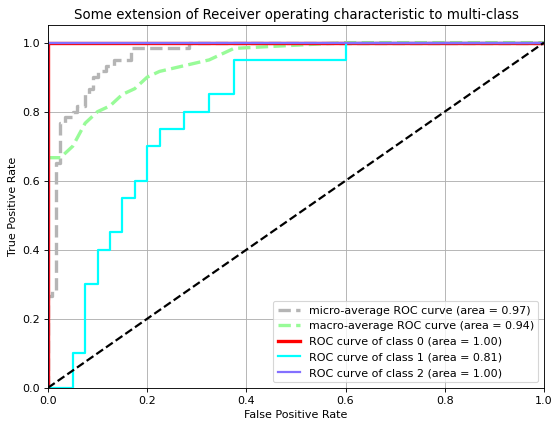

In [36]:
# Plot all ROC curves
lw=2
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='#B5B5B5', linestyle='--', linewidth=3)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='#98FB98', linestyle='--', linewidth=3)

colors = cycle(['#FF0000', '#00FFFF', '#8470FF'])
for i, color in zip(range(n_classes), colors):
    if i == 0:
        plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    else:
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1],'k--', lw=lw )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.grid()
plt.legend(loc="lower right")
plt.show()

### Learning curve
- According to the training sample size，show the changes in accuracy.

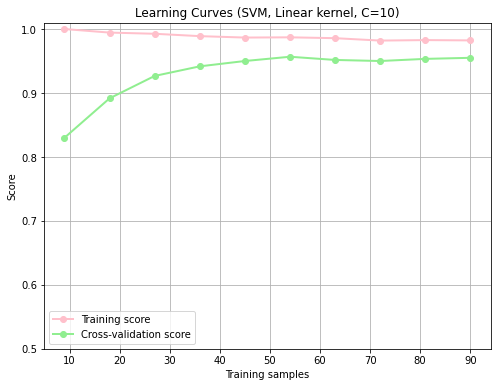

In [37]:
plt.figure(figsize=(8, 6))
lw = 2
title = r"Learning Curves (SVM, Linear kernel, C=10)"
plt.title(title)

# modeling
clf = svm.SVC(kernel='linear', C=10)    

# Set the range of Y axis
plt.ylim((.5, 1.01))
plt.xlabel("Training samples")
plt.ylabel("Score")

# Get the data needed to draw the learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=66)
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1, 10))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Draw the graphl
plt.plot(train_sizes, train_scores_mean, 'o-', color="pink",lw=lw,
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="lightgreen", lw=lw,
         label="Cross-validation score")
plt.grid()
plt.legend(loc="best")
plt.show()

### Validation curve
- According to the different value of parameter C in SVM classifier，show the changes in accuracy.

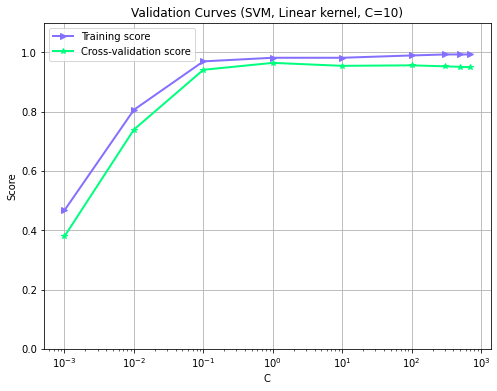

In [38]:
plt.figure(figsize=(8, 6))
lw = 2
title = r"Validation Curves (SVM, Linear kernel, C=10)"
plt.title(title)

# modeling
clf = svm.SVC(kernel='linear', C=10) 

# Get the data needed to draw the validation curve
param_range = [0.001, 0.01, 0.1, 1, 10.0, 100.0, 300, 500, 700]
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=66)
train_scores, test_scores = validation_curve(
   clf, X, y, param_name="C", param_range=param_range, cv=cv, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

#Draw the graph 
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
#Semi logarithmic coordinate function: only one coordinate axis is logarithmic coordinate,and the other is ordinary arithmetic coordinate.
#Here we use this method to draw pictures, because C changes exponentially.
plt.semilogx(param_range, train_scores_mean, label="Training score", marker='>',
             color="#8470FF", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", marker='*',
             color="#00FF7F", lw=lw)
plt.grid()
plt.legend(loc="best")
plt.show()